In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [2]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph bs4
%pip install faiss-cpu --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -qU "langchain[mistralai]"


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import getpass
import os

if not os.environ.get("MISTRAL_API_KEY"):
  os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter API key for Mistral AI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("mistral-large-latest", model_provider="mistralai")

In [5]:
%pip install -qU langchain-mistralai


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import getpass
import os

if not os.environ.get("MISTRALAI_API_KEY"):
  os.environ["MISTRALAI_API_KEY"] = getpass.getpass("Enter API key for MistralAI: ")

from langchain_mistralai import MistralAIEmbeddings

embeddings = MistralAIEmbeddings(model="mistral-embed")

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/langchain_mistralai/embeddings.py:186: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


In [7]:
os.environ["LANGSMITH_TRACING"] = "true"
#for visualising traces
langsmith_key=os.getenv("LANGSMITH_API_KEY")

In [8]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

embedding_dim = len(embeddings.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [9]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://www.cambridge.org/core/services/aop-cambridge-core/content/view/D7B259BCD35586E04358DF06006E0A85/S2977042424000530a",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

prompt = hub.pull("rlm/rag-prompt")

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

ValueError: not enough values to unpack (expected 2, got 1)

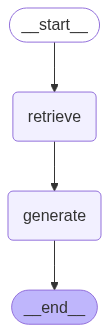

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
response = graph.invoke({"question": "What are the three main points of this document?"})
print(response["answer"])

NameError: name 'graph' is not defined